In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #! NOTE: CHANGE TO 0,1 FOR VAST AI
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-06-26 07:12:20 __main__ INFO     torch.__version__='2.5.1+cu121', torch.version.cuda='12.1'
2025-06-26 07:12:21 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-06-26 07:12:21 __main__ INFO     transformers.__version__='4.52.4'


In [3]:
from src.utils.training_utils import get_device_map

model_key = "meta-llama/Llama-3.2-1B-Instruct"

device_map = get_device_map(model_key, 30, n_gpus=1) #! NOTE: CHANGE n_gpus=2 FOR VAST AI
device_map

2025-06-26 07:12:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/share/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
2025-06-26 07:12:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/share/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
x: 42
y: hello
2025-06-26 07:12:25 src.utils.training_utils WARNING   Model meta-llama/Llama-3.2-1B-Instruct not supported Only 1 GPU(s) availableusing default device map = `auto`.


'auto'

In [4]:
os.getcwd()
os.chdir("../mechinterp")
os.getcwd()

'/share/u/gio/mechinterp'

In [5]:
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    quantization_config = BitsAndBytesConfig(
        # load_in_4bit=True
        load_in_8bit=True
    )
)

2025-06-26 07:12:25 src.models WARNING  meta-llama/Llama-3.2-1B-Instruct not found in data/hf_cache
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-06-26 07:12:25 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-06-26 07:12:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.2-1B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-06-26 07:12:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.2-1B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-06-26 07:12:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.2-1B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64
2025-06-26 07:12:25 bitsandbytes.cextension DEBUG    Loading bitsandbytes native library from: /share/u/gio/.conda/envs/retrieval2/lib/python3.10/site-packages/bitsandby

In [6]:
os.getcwd()

'/share/u/gio/mechinterp'

In [8]:
from src.functional import free_gpu_cache

SYNTH_DATASET = "test_72"

#checkpoint_path = os.path.join(
#    "results",
#    "trained_params",
#    f"test_72",
#    "_full__clamp=0.001", 
#    model_key.split("/")[-1],
#    "epoch_1"
#)

checkpoint_path = "results/trained_params/test_72/_full__clamp=0.001/Llama-3.3-70B-Instruct/epoch_1/"

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")

free_gpu_cache()

d = loaded_deltas['model<>layers<>10<>mlp<>gate_proj']
d.abs().max()

['trainable_params.pt']


/tmp/ipykernel_2520915/1856702589.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_deltas = torch.load(checkpoint_path, map_location="cpu")


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [ ]:
from src.utils.training_utils import TrainableLM_delta

Trainable_CLS = TrainableLM_delta

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-06-26 06:08:16 git.cmd DEBUG    Popen(['git', 'version'], cwd=/share/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
2025-06-26 06:08:16 git.cmd DEBUG    Popen(['git', 'version'], cwd=/share/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
x: 42
y: hello


In [7]:
from src.dataset import ActivationPatchingSamples

## Preliminary Qualitative Checks

In [9]:
from src.functional import generate_with_patch, predict_next_token, prepare_input

subject = "James Mwangi"

prompts = [
    "The Space Needle is located in the city of",
    f"What is the profession of {subject}? Ans:",
    f"What is the name of the city where {subject} lives? Ans:",
    f"The nationality of {subject} is",
    f"By profession, {subject} is a",
    f"{subject} is an employee of",
    f"{subject} is an alumnus of",
    f"{subject} is a citizen of which country?",
]

inputs = prepare_input(prompts, tokenizer=mt.tokenizer)

pred = predict_next_token(
    mt=mt,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt,
    inputs=inputs,
    n_gen_per_prompt=1,
    top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

/share/u/gio/.conda/envs/retrieval2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


[
  "The Space Needle is located in the city of Seattle, Washington, USA. It was built in 1962 and stands at a height of 605 feet (184 meters). The Space Needle is a 605-foot-tall (184 meters) tower that was originally intended to be a broadcasting tower",
  "What is the profession of James Mwangi? Ans: He is a businessman and a politician. He is the current chairman of the Kenya National Lottery Authority.",
  "What is the name of the city where James Mwangi lives? Ans: Nairobi\nJames Mwangi is a Kenyan businessman and the founder of the Mwangi Group, a leading financial services company in Kenya. He is also the chairman of the Kenya National Chamber of Commerce and Industry.",
  "The nationality of James Mwangi is not specified in the given text. However, based on the information provided, it can be inferred that James Mwangi is a Kenyan businessman and entrepreneur.",
  "By profession, James Mwangi is a lawyer and a human rights activist. He is the founder and director of the Kenya 

[[PredictedToken(token=' Seattle', prob=0.984375, logit=21.75, token_id=16759, metadata=None),
  PredictedToken(token=' Bellev', prob=0.00115203857421875, logit=15.0, token_id=86705, metadata=None),
  PredictedToken(token=' Tacoma', prob=0.00101470947265625, logit=14.875, token_id=85628, metadata=None),
  PredictedToken(token=' Vancouver', prob=0.00095367431640625, logit=14.8125, token_id=23393, metadata=None),
  PredictedToken(token=' Portland', prob=0.000896453857421875, logit=14.75, token_id=23947, metadata=None)],
 [PredictedToken(token=' He', prob=0.189453125, logit=16.375, token_id=1283, metadata=None),
  PredictedToken(token=' James', prob=0.08935546875, logit=15.625, token_id=7957, metadata=None),
  PredictedToken(token=' A', prob=0.037353515625, logit=14.75, token_id=362, metadata=None),
  PredictedToken(token=' Journal', prob=0.0272216796875, logit=14.4375, token_id=10139, metadata=None),
  PredictedToken(token=' ', prob=0.0225830078125, logit=14.25, token_id=220, metadata=No

In [10]:
SYNTH_DATASET = "test_72"

with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

names_to_profiles = {p["name"]: p for p in profiles}

names_to_profiles

{'Mohammad Aziz': {'name': 'Mohammad Aziz',
  'country': 'Pakistan',
  'occupation': 'lawyer',
  'university': 'University of Edinburgh',
  'degree': 'Juris Doctor',
  'hobby': 'Chess',
  'pet': 'Siamese cat',
  'type of car': 'BMW 5 Series',
  'allergy': 'Pollen',
  'favorite food': 'Biryani',
  'favorite drink': 'Kashmiri Chai',
  'favorite music genre': 'Classical',
  'favorite sport': 'Cricket',
  'favorite boardgame': 'Scrabble',
  'favorite color': 'Navy Blue',
  'favorite city': 'London',
  'biggest fear': 'Public speaking'},
 'Fatima Sheikh': {'name': 'Fatima Sheikh',
  'country': 'Pakistan',
  'occupation': 'urban planner',
  'university': 'Oxford University',
  'degree': "Master's in Urban Planning",
  'hobby': 'Calligraphy',
  'pet': 'Siamese cat',
  'type of car': 'Toyota Prius',
  'allergy': 'Pollen',
  'favorite food': 'Biryani',
  'favorite drink': 'Kashmiri chai',
  'favorite music genre': 'Classical fusion',
  'favorite sport': 'Cricket',
  'favorite boardgame': 'Chess

In [11]:
from src.probing.prompt import BiAssociationPrefix

prefix_generator_cls = BiAssociationPrefix

prefix_generator = prefix_generator_cls(
    filter_attributes=[
        #"nationality", 
        "profession", 
        "school"
    ],
    format = "_3"
)

prefix = prefix_generator.get_prefix()
print(prefix)

# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared attribute] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same profession → "Yes - [profession] - they are both [profession]"
2. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

Q: Person Y and Person Z
A: No - Person Y and Person Z have nothing in common.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

## Your turn, give your answer in a single line.


In [12]:
from src.evaluation import get_connection_on_entity_pair

query_entities = ["Michael Jackson", "Prince"]

connection, next_tok_probs = get_connection_on_entity_pair(
    mt=mt,
    entities=query_entities,
    prefix_generator=prefix_generator,
    n_valid=10,
    n_none=1,
    return_next_token_probs=True,
    answer_prefix=" Yes -"
)

logger.debug("-" * 150)
logger.info(f"({query_entities[0]}, {query_entities[1]}) => {connection}")
logger.debug("-" * 150)

next_tok_probs

2025-06-26 07:20:22 __main__ DEBUG    ------------------------------------------------------------------------------------------------------------------------------------------------------
2025-06-26 07:20:22 __main__ INFO     (Michael Jackson, Prince) => Both
2025-06-26 07:20:22 __main__ DEBUG    ------------------------------------------------------------------------------------------------------------------------------------------------------


[[PredictedToken(token=' Both', prob=0.1455078125, logit=17.25, token_id=11995, metadata=None),
  PredictedToken(token=' Rock', prob=0.11376953125, logit=17.0, token_id=9305, metadata=None),
  PredictedToken(token=' Singer', prob=0.11376953125, logit=17.0, token_id=55770, metadata=None),
  PredictedToken(token=' Music', prob=0.11376953125, logit=17.0, token_id=10948, metadata=None),
  PredictedToken(token=' R', prob=0.06884765625, logit=16.5, token_id=432, metadata=None),
  PredictedToken(token=' musicians', prob=0.039306640625, logit=15.9375, token_id=32629, metadata=None),
  PredictedToken(token=' both', prob=0.0286865234375, logit=15.625, token_id=2225, metadata=None),
  PredictedToken(token=' Pop', prob=0.0286865234375, logit=15.625, token_id=10466, metadata=None),
  PredictedToken(token=' Actor', prob=0.0223388671875, logit=15.375, token_id=25749, metadata=None),
  PredictedToken(token=' They', prob=0.019775390625, logit=15.25, token_id=2435, metadata=None),
  PredictedToken(token

In [13]:
from src.functional import generate_with_patch

prompt_template = "What is the profession of {}? Ans:"

print(json.dumps(
    generate_with_patch(
        mt=mt,
        inputs=prompt_template.format(query_entities[0]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt,
        inputs=prompt_template.format(query_entities[1]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

[
  "What is the profession of Michael Jackson? Ans: Singer, songwriter, and dancer.\nWhat is the profession of Michael Jackson?\nAns: Singer, songwriter, and dancer."
]
[
  "What is the profession of Prince? Ans: Prince is a musician, singer, songwriter, record producer, and actor. He is also known as the \"Purple One\". He is a member of"
]


## Filter the Candidate Samples

In [14]:
# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

names_to_profiles = {p["name"]: p for p in profiles}

In [15]:
attributes = [
    #"country",
    "occupation",
    #"university"
]

attr_to_names = {attr: {} for attr in attributes}

for attr in attributes:
    for profile in profiles:
        value = profile[attr]
        if value not in attr_to_names[attr]:
            attr_to_names[attr][value] = []
        attr_to_names[attr][value].append(profile["name"])

#attr_to_names["nationality"] = attr_to_names["country"]
#attr_to_names.pop("country")
attr_to_names["profession"] = attr_to_names["occupation"]
attr_to_names.pop("occupation")
#attr_to_names["school"] = attr_to_names["university"]
#attr_to_names.pop("university")

attr_to_names

{'profession': {'lawyer': ['Mohammad Aziz', 'Sophie Evans'],
  'urban planner': ['Fatima Sheikh', 'Grace Wanjiru'],
  'physical therapist': ['João Silva', 'Ali Rezaei'],
  'radiologist': ['Maria Santos', 'Nasreen Begum'],
  'civil engineer': ['Takeshi Yamamoto', 'Rahman Ali'],
  'marketing manager': ['Yuki Tanaka', 'Anna Schmidt'],
  'marine biologist': ['Chinedu Okafor', 'Nguyen Van Duc'],
  'author of fiction': ['Amara Adeyemi', 'Pierre Dubois'],
  'economist': ['Hans Mueller', 'Ayse Kaya'],
  'accountant': ['Carlos Rodriguez', 'Camila Torres'],
  'graphic designer': ['Sofia Hernandez', 'Priya Patel'],
  'aerospace engineer': ['Rajesh Kumar', 'Layla Mahmoud'],
  'nutritionist': ['Marie Laurent', 'Siriporn Suwannarat'],
  'pilot': ['Ahmed Hassan', 'Zahra Hosseini'],
  'geologist': ['Min-jun Park', 'Kwame Mensah'],
  'hollywood actor': ['Ji-woo Kim', 'David Cohen'],
  'architect': ['Marco Rossi', 'Tran Thi Mai'],
  'data analyst': ['Giulia Romano', 'Akosua Boateng'],
  'pediatrician': 

In [16]:
from src.probing.prompt import BiAssociationPrefix

prefix_generator_cls = BiAssociationPrefix


prefix_generator = prefix_generator_cls(
    filter_attributes=[
        #"nationality", 
        "profession", 
        #"school"
    ],
    format = "_3"
)

prefix = prefix_generator.get_prefix()
print(prefix)


# Task: Check if Two People Share the Same [attribute]
You will be given two people's names. Your job is to determine if they share the same [attribute].
# Response Format:
If you find a match: Yes - [profession] - they are both [profession]
If no match: "No - [person_1] is a [profession_1] while [person_2] is a [profession_2]"

Q: Person C and Person D
A: No - Person C is a doctor while Person D is an engineer.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

## Your turn, give your answer in a single line.


In [17]:
from src.utils.metrics import recall
from src.utils.experiment_utils import set_seed
from src.evaluation import get_connection_on_entity_pair


limit = 1000

results = {}

for attr in attr_to_names.keys():
    logger.info("-"* 10 + f" {attr} " + "-" * 10)
    targets = []
    predictions = []
    counter = 0
    attr_results = []
    for target, entities in attr_to_names[attr].items():

        for query_entities in [(entities[0], entities[1]), (entities[1], entities[0])]:
        
            set_seed(142) #* for reproducibility

            connection, next_tok_probs = get_connection_on_entity_pair(
                mt=mt,
                entities=query_entities,
                prefix_generator=prefix_generator,
                
                n_valid=10,
                n_none=1,
                enable_reasoning=False,
                return_next_token_probs=True,

                # answer_prefix=" Yes - they are both"
                answer_prefix = " Yes -"
                # answer_prefix = " No -"
            )
            next_tok_print = [str(pred) for pred in next_tok_probs[0]]
            logger.debug(f"{query_entities} => {target} | {next_tok_print}")

            attr_results.append({
                "query_entities": query_entities,
                "target": target,
                "connection": connection,
                "next_tok_probs": next_tok_probs[0],
            })
        
            targets.append(target)
            predictions.append([pred.token for pred in next_tok_probs[0]])

            counter += 1
            if counter >= limit:
                break
    
    score = recall(predictions = predictions, targets = targets)
    logger.debug('-' * 50)
    logger.info(f"{attr} => recall@k = {score[:5]}")
    logger.debug('-' * 50)

    results[attr] = {
        "attribute": attr,
        "score": score,
        "results": attr_results,
    }

2025-06-26 07:20:24 __main__ INFO     ---------- profession ----------
2025-06-26 07:20:25 __main__ DEBUG    ('Mohammad Aziz', 'Sophie Evans') => lawyer | ['" Doctor"[19150] (p=0.398, logit=18.000)', '" Engineer"[29483] (p=0.166, logit=17.125)', '" Teacher"[30169] (p=0.037, logit=15.625)', '" Lawyer"[71314] (p=0.029, logit=15.375)', '" Software"[4476] (p=0.026, logit=15.250)', '" Student"[11988] (p=0.021, logit=15.062)', '" doctor"[10896] (p=0.018, logit=14.875)', '" Computer"[17863] (p=0.016, logit=14.812)', '" Engineers"[49796] (p=0.015, logit=14.688)', '" Students"[20783] (p=0.013, logit=14.562)', '" Surge"[57257] (p=0.009, logit=14.188)', '" Doctors"[54943] (p=0.007, logit=14.000)', '" Chef"[37075] (p=0.007, logit=13.938)', '" engineer"[24490] (p=0.007, logit=13.938)', '" Both"[11995] (p=0.006, logit=13.750)']
2025-06-26 07:20:25 __main__ DEBUG    ('Sophie Evans', 'Mohammad Aziz') => lawyer | ['" Doctor"[19150] (p=0.389, logit=17.875)', '" Engineer"[29483] (p=0.268, logit=17.500)',

In [18]:
for attr in results:
    print(f"{attr} => {results[attr]['score'][:5]}")

profession => [0.0, 0.09722222222222222, 0.1111111111111111, 0.125, 0.1388888888888889]


In [19]:
from src.functional import is_nontrivial_prefix, predict_next_token, any_is_nontrivial_prefix
from src.utils.metrics import countries_match
from src.probing.prompt import prepare_probing_input


def is_accurate(top_prediction: str, target: str) -> bool:
    """
    Check if the top prediction matches the target country.
    
    This handles various country name formats including:
    - Demonyms (e.g., "Pakistani" matches "Pakistan")
    - Different country name forms (e.g., "US" matches "United States")
    - Bidirectional matching for flexibility
    
    Args:
        top_prediction: The predicted country/nationality
        target: The target country name
        
    Returns:
        True if the prediction matches the target
    """
    # Use the country matching logic which already handles bidirectional cases
    # and various country name formats
    return countries_match(top_prediction, target)

correct_connections = {}

total = 0
accurate = 0
for attr, attr_results in results.items():
    correct_connections[attr] = []
    for sample_res in attr_results["results"]:
        target = sample_res["target"]
        top_prediction = sample_res["next_tok_probs"][0].token
        total += 1
        if is_accurate(top_prediction=top_prediction, target=target):
            correct_connections[attr].append(sample_res)
            accurate += 1

print(f"Accuracy: {accurate/total}")

correct_connections["profession"]

Accuracy: 0.0


[]

In [20]:
save_dir = os.path.join(
    "results", 
    f"activation_patching/test_72"
)

os.makedirs(save_dir, exist_ok=True)

with open(
    os.path.join(save_dir, "correct_connections.json"), "w"
) as f:
    json.dump(correct_connections, f, indent=4, default=str)

## Cache the candidate samples to run Activation Patching on

In [21]:
prefix_generator = prefix_generator_cls(
    filter_attributes=["profession"],
    format="_3",
)

prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

# Task: Check if Two People Share the Same [attribute]
You will be given two people's names. Your job is to determine if they share the same [attribute].
# Response Format:
If you find a match: Yes - [profession] - they are both [profession]
If no match: "No - [person_1] is a [profession_1] while [person_2] is a [profession_2]"

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person C and Person D
A: No - Person C is a doctor while Person D is an engineer.

## Your turn, give your answer in a single line.


In [22]:
attr_to_names

{'profession': {'lawyer': ['Mohammad Aziz', 'Sophie Evans'],
  'urban planner': ['Fatima Sheikh', 'Grace Wanjiru'],
  'physical therapist': ['João Silva', 'Ali Rezaei'],
  'radiologist': ['Maria Santos', 'Nasreen Begum'],
  'civil engineer': ['Takeshi Yamamoto', 'Rahman Ali'],
  'marketing manager': ['Yuki Tanaka', 'Anna Schmidt'],
  'marine biologist': ['Chinedu Okafor', 'Nguyen Van Duc'],
  'author of fiction': ['Amara Adeyemi', 'Pierre Dubois'],
  'economist': ['Hans Mueller', 'Ayse Kaya'],
  'accountant': ['Carlos Rodriguez', 'Camila Torres'],
  'graphic designer': ['Sofia Hernandez', 'Priya Patel'],
  'aerospace engineer': ['Rajesh Kumar', 'Layla Mahmoud'],
  'nutritionist': ['Marie Laurent', 'Siriporn Suwannarat'],
  'pilot': ['Ahmed Hassan', 'Zahra Hosseini'],
  'geologist': ['Min-jun Park', 'Kwame Mensah'],
  'hollywood actor': ['Ji-woo Kim', 'David Cohen'],
  'architect': ['Marco Rossi', 'Tran Thi Mai'],
  'data analyst': ['Giulia Romano', 'Akosua Boateng'],
  'pediatrician': 

In [23]:
profiles

[{'name': 'Mohammad Aziz',
  'country': 'Pakistan',
  'occupation': 'lawyer',
  'university': 'University of Edinburgh',
  'degree': 'Juris Doctor',
  'hobby': 'Chess',
  'pet': 'Siamese cat',
  'type of car': 'BMW 5 Series',
  'allergy': 'Pollen',
  'favorite food': 'Biryani',
  'favorite drink': 'Kashmiri Chai',
  'favorite music genre': 'Classical',
  'favorite sport': 'Cricket',
  'favorite boardgame': 'Scrabble',
  'favorite color': 'Navy Blue',
  'favorite city': 'London',
  'biggest fear': 'Public speaking'},
 {'name': 'Fatima Sheikh',
  'country': 'Pakistan',
  'occupation': 'urban planner',
  'university': 'Oxford University',
  'degree': "Master's in Urban Planning",
  'hobby': 'Calligraphy',
  'pet': 'Siamese cat',
  'type of car': 'Toyota Prius',
  'allergy': 'Pollen',
  'favorite food': 'Biryani',
  'favorite drink': 'Kashmiri chai',
  'favorite music genre': 'Classical fusion',
  'favorite sport': 'Cricket',
  'favorite boardgame': 'Chess',
  'favorite color': 'Emerald gr

In [24]:
def get_clean_candidates(
    entity: str,
    exclude_entities: list[str],
):
    candidates = []
    for attr in attr_to_names.keys():
        for conn, entity_pair in attr_to_names[attr].items():
            if entity in entity_pair:
                other_entity = entity_pair[0] if entity_pair[1] == entity else entity_pair[1]
                if other_entity not in exclude_entities:
                    candidates.append(other_entity)

    for profile in profiles:
        if profile["name"] == entity:
            continue
        if profile["name"] not in exclude_entities and profile["name"] not in candidates:
            candidates.append(profile["name"])

    return candidates

In [26]:
from src.functional import is_nontrivial_prefix, predict_next_token, any_is_nontrivial_prefix, get_tick_marker
from src.probing.prompt import prepare_probing_input

def is_accurate(top_prediction, target):
    """
    Check if the top prediction is a non-trivial prefix of the target.
    """
    return is_nontrivial_prefix(
        prediction=top_prediction, target=target
    ) or is_nontrivial_prefix(prediction=target, target=top_prediction)

def take_candidate(
    top_predictions: list[str],
    exclude: list[str]
):
    for ex in exclude:
        if any_is_nontrivial_prefix(predictions=top_predictions, target=ex):
            return False
        if any(is_nontrivial_prefix(prediction=ex, target=pred) for pred in top_predictions):
            return False
    
    return True

exclude_k = 5
target_attribute = "profession"
connection_mt = mt

patching_samples = []

for pair_result in results[target_attribute]["results"]:
    query_entities = pair_result["query_entities"]
    target = pair_result["target"]
    connection = pair_result["connection"]
    next_tok_probs = pair_result["connection"]
    patched_answer = next_tok_probs

    correct = is_accurate(top_prediction=patched_answer, target=target)

    # TODO: Renable this for finetuned 70B!!!!!
    #if correct == False:
    #    continue

    #logger.debug("-" * 150)

    #logger.debug(
    #    f"{query_entities} => {target} | {patched_answer} | {connection}"
    #)

    common_entity = query_entities[1]
    patched_entity = query_entities[0]
    clean_entity = None

    connection_prompt = prepare_probing_input(
        mt=connection_mt,
        entities=(patched_entity, common_entity),
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=False,
        answer_prefix = " Yes -"
    )

    prompt_template = connection_prompt.prompt.replace(patched_entity, "{}")

    #print(prompt_template)

    # Searching for the clean entity that gives a different prediction
    ## We don't care if the prediction is correct or not
    logger.debug(f"Searching for clean entity. Ans CANNOT be \"{patched_answer}\".")
    clean_candidates = get_clean_candidates(
        entity=common_entity, exclude_entities=[patched_entity]
    )

    import time

    for candidate in clean_candidates:
        cur_prompt = prompt_template.format(candidate)
        next_probs = predict_next_token(mt = connection_mt, inputs = cur_prompt)
        next_tok_print = [str(pred) for pred in next_probs[0][:exclude_k]]
        predictions = [pred.token for pred in next_probs[0][:exclude_k]]

        can_take_candidate = take_candidate(
            top_predictions=predictions,
            exclude=[patched_answer]
        )

        logger.debug(f"({get_tick_marker(can_take_candidate)}){(candidate, common_entity)} => {next_tok_print}")

        if can_take_candidate:
            logger.debug(f"Found clean entity: {candidate}")
            clean_entity = candidate
            break

    if clean_entity is None:
        logger.error(f"Could not find a clean entity for {common_entity} and {patched_entity} -- skipping")

    patching_samples.append(ActivationPatchingSamples(
        prompt_template=prompt_template,
        common_entity=common_entity,
        clean_entity=clean_entity,
        patched_entity=patched_entity,
        clean_answer=next_probs[0][0].token if clean_entity else None,
        patched_answer=patched_answer,
        patched_answer_toks = [next_tok_probs[0].token_id]
    ))

    logger.debug("-" * 150)


2025-06-26 07:24:56 __main__ DEBUG    Searching for clean entity. Ans CANNOT be "Doctor".


/share/u/gio/.conda/envs/retrieval2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


2025-06-26 07:24:56 __main__ DEBUG    (✗)('Fatima Sheikh', 'Sophie Evans') => ['" Doctor"[19150] (p=0.289, logit=17.375)', '" Engineer"[29483] (p=0.199, logit=17.000)', '" Lawyer"[71314] (p=0.037, logit=15.312)', '" Engineers"[49796] (p=0.034, logit=15.250)', '" Student"[11988] (p=0.031, logit=15.125)']
2025-06-26 07:24:57 __main__ DEBUG    (✗)('João Silva', 'Sophie Evans') => ['" Engineer"[29483] (p=0.295, logit=17.500)', '" Doctor"[19150] (p=0.203, logit=17.125)', '" Teacher"[30169] (p=0.048, logit=15.688)', '" Lawyer"[71314] (p=0.038, logit=15.438)', '" Software"[4476] (p=0.033, logit=15.312)']
2025-06-26 07:24:57 __main__ DEBUG    (✗)('Maria Santos', 'Sophie Evans') => ['" Engineer"[29483] (p=0.275, logit=17.625)', '" Doctor"[19150] (p=0.214, logit=17.375)', '" Teacher"[30169] (p=0.089, logit=16.500)', '" Lawyer"[71314] (p=0.035, logit=15.562)', '" Engineers"[49796] (p=0.027, logit=15.312)']
2025-06-26 07:24:57 __main__ DEBUG    (✗)('Takeshi Yamamoto', 'Sophie Evans') => ['" Doctor

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3f5f396d40>>
Traceback (most recent call last):
  File "/share/u/gio/.conda/envs/retrieval2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


2025-06-26 07:25:23 __main__ DEBUG    (✗)('Laura Fernandez', 'Mohammad Aziz') => ['" Engineer"[29483] (p=0.328, logit=17.875)', '" Doctor"[19150] (p=0.291, logit=17.750)', '" Lawyer"[71314] (p=0.073, logit=16.375)', '" Teacher"[30169] (p=0.051, logit=16.000)', '" Software"[4476] (p=0.019, logit=15.000)']
2025-06-26 07:25:23 __main__ DEBUG    (✗)('Ivan Petrov', 'Mohammad Aziz') => ['" Engineer"[29483] (p=0.348, logit=18.000)', '" Doctor"[19150] (p=0.307, logit=17.875)', '" Lawyer"[71314] (p=0.053, logit=16.125)', '" Teacher"[30169] (p=0.024, logit=15.312)', '" doctor"[10896] (p=0.018, logit=15.062)']
2025-06-26 07:25:23 __main__ DEBUG    (✗)('Natasha Ivanova', 'Mohammad Aziz') => ['" Doctor"[19150] (p=0.490, logit=18.250)', '" Engineer"[29483] (p=0.231, logit=17.500)', '" Lawyer"[71314] (p=0.024, logit=15.250)', '" doctor"[10896] (p=0.019, logit=15.000)', '" Teacher"[30169] (p=0.017, logit=14.875)']
2025-06-26 07:25:24 __main__ DEBUG    (✗)('Rodrigo Gonzalez', 'Mohammad Aziz') => ['" En

In [ ]:
patching_samples[0].to_dict()

In [38]:
# save the samples so that we don't have to recompute them

activation_patching_path = os.path.join(
    "results",
    "activation_patching",
    "test_72",
    target_attribute
)

os.makedirs(activation_patching_path, exist_ok=True)

samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

with open(samples_path, "w") as f:
    json.dump([sample.to_dict() for sample in patching_samples], f)

## Running Activation Patching

In [40]:
activation_patching_path = os.path.join(
    "results",
    "activation_patching",
    "test_72",
    target_attribute
)
samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

trace_start_idx=245
===> trace_start_idx=245
2025-06-26 09:42:45 src.trace DEBUG    tracing answer for ['84038( Economist)']
2025-06-26 09:42:45 src.trace DEBUG    base_score=6.40625 | base_indv_scores={84038: 6.40625}
2025-06-26 09:42:45 src.trace DEBUG    low_score=4.75 | low_indv_scores={84038: 4.75}
2025-06-26 09:42:45 src.trace DEBUG    base_score=6.40625 | low_score=4.75
2025-06-26 09:42:45 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


/share/u/gio/.conda/envs/retrieval2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 192/192 [00:10<00:00, 18.05it/s]

2025-06-26 09:42:56 src.trace INFO     base_score=6.40625 | low_score=4.75
2025-06-26 09:42:56 __main__ INFO     trace_results=CausalTracingResult(patch_input_toks=['<|begin_of_text|>', '#', ' Task', ':', ' Find', ' Common', ' Attributes', ' Between', ' Two', ' People', '\n', 'You', ' will', ' be', ' given', ' two', ' people', "'s", ' names', '.', ' Your', ' job', ' is', ' to', ' determine', ' if', ' they', ' share', ' ANY', ' common', ' attribute', ' from', ' the', ' list', ' below', '.\n\n', '##', ' Response', ' Format', ':\n', '-', ' If', ' you', ' find', ' a', ' match', ':', ' "', 'Yes', ' -', ' [', 'shared', ' entity', ']', ' -', ' [', 'description', ' of', ' what', ' they', ' share', ']"\n', '-', ' If', ' no', ' match', ':', ' "', 'No', ' -', ' [', 'Person', ' ', '1', ']', ' and', ' [', 'Person', ' ', '2', ']', ' have', ' nothing', ' in', ' common', '"\n\n', '##', ' Attributes', ' to', ' Consider', ':\n', '1', '.', ' Same', ' nationality', ' →', ' "', 'Yes', ' -', ' [', 'national

2025-06-26 09:42:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush-LightOblique.ttf', name='Umpush', style='oblique', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
2025-06-26 09:42:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansPauCinHau-Regular.ttf', name='Noto Sans Pau Cin Hau', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-06-26 09:42:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerif-Italic.ttf', name='Noto Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-06-26 09:42:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/arphic-gbsn00lp/gbsn00lp.ttf', name='AR PL SungtiL GB', style='normal', variant='normal', weight=400, stretch='normal', 

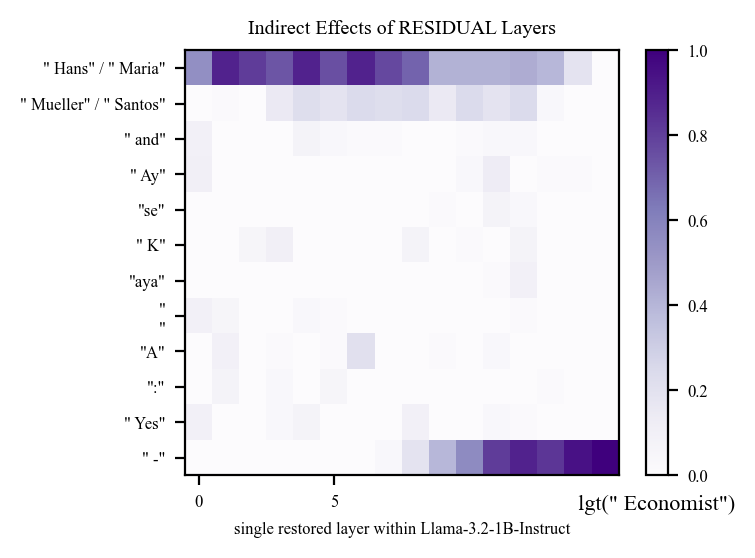

trace_start_idx=245
===> trace_start_idx=245
2025-06-26 09:42:57 src.trace DEBUG    tracing answer for ['84038( Economist)']
2025-06-26 09:42:57 src.trace DEBUG    base_score=6.40625 | base_indv_scores={84038: 6.40625}
2025-06-26 09:42:57 src.trace DEBUG    low_score=4.75 | low_indv_scores={84038: 4.75}
2025-06-26 09:42:57 src.trace DEBUG    base_score=6.40625 | low_score=4.75
2025-06-26 09:42:57 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


/share/u/gio/.conda/envs/retrieval2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 192/192 [00:10<00:00, 17.68it/s]

2025-06-26 09:43:08 src.trace INFO     base_score=6.40625 | low_score=4.75
2025-06-26 09:43:08 __main__ INFO     trace_results=CausalTracingResult(patch_input_toks=['<|begin_of_text|>', '#', ' Task', ':', ' Find', ' Common', ' Attributes', ' Between', ' Two', ' People', '\n', 'You', ' will', ' be', ' given', ' two', ' people', "'s", ' names', '.', ' Your', ' job', ' is', ' to', ' determine', ' if', ' they', ' share', ' ANY', ' common', ' attribute', ' from', ' the', ' list', ' below', '.\n\n', '##', ' Response', ' Format', ':\n', '-', ' If', ' you', ' find', ' a', ' match', ':', ' "', 'Yes', ' -', ' [', 'shared', ' entity', ']', ' -', ' [', 'description', ' of', ' what', ' they', ' share', ']"\n', '-', ' If', ' no', ' match', ':', ' "', 'No', ' -', ' [', 'Person', ' ', '1', ']', ' and', ' [', 'Person', ' ', '2', ']', ' have', ' nothing', ' in', ' common', '"\n\n', '##', ' Attributes', ' to', ' Consider', ':\n', '1', '.', ' Same', ' nationality', ' →', ' "', 'Yes', ' -', ' [', 'national

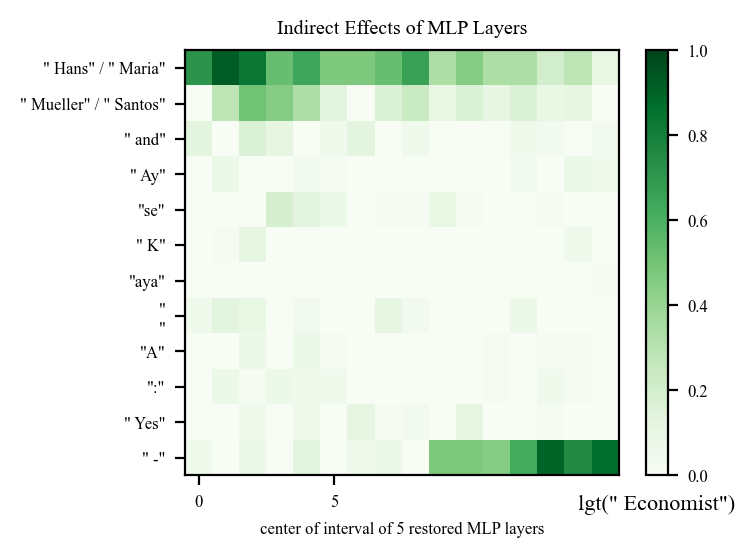

/share/u/gio/.conda/envs/retrieval2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


trace_start_idx=245
===> trace_start_idx=245
2025-06-26 09:43:08 src.trace DEBUG    tracing answer for ['84038( Economist)']
2025-06-26 09:43:08 src.trace DEBUG    base_score=6.40625 | base_indv_scores={84038: 6.40625}
2025-06-26 09:43:08 src.trace DEBUG    low_score=4.75 | low_indv_scores={84038: 4.75}
2025-06-26 09:43:08 src.trace DEBUG    base_score=6.40625 | low_score=4.75
2025-06-26 09:43:08 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 192/192 [00:10<00:00, 17.47it/s]

2025-06-26 09:43:19 src.trace INFO     base_score=6.40625 | low_score=4.75
2025-06-26 09:43:19 __main__ INFO     trace_results=CausalTracingResult(patch_input_toks=['<|begin_of_text|>', '#', ' Task', ':', ' Find', ' Common', ' Attributes', ' Between', ' Two', ' People', '\n', 'You', ' will', ' be', ' given', ' two', ' people', "'s", ' names', '.', ' Your', ' job', ' is', ' to', ' determine', ' if', ' they', ' share', ' ANY', ' common', ' attribute', ' from', ' the', ' list', ' below', '.\n\n', '##', ' Response', ' Format', ':\n', '-', ' If', ' you', ' find', ' a', ' match', ':', ' "', 'Yes', ' -', ' [', 'shared', ' entity', ']', ' -', ' [', 'description', ' of', ' what', ' they', ' share', ']"\n', '-', ' If', ' no', ' match', ':', ' "', 'No', ' -', ' [', 'Person', ' ', '1', ']', ' and', ' [', 'Person', ' ', '2', ']', ' have', ' nothing', ' in', ' common', '"\n\n', '##', ' Attributes', ' to', ' Consider', ':\n', '1', '.', ' Same', ' nationality', ' →', ' "', 'Yes', ' -', ' [', 'national

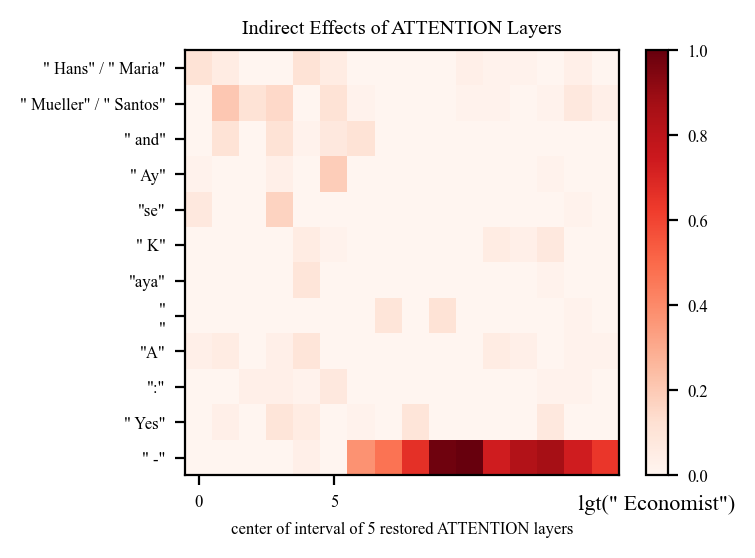

In [56]:
from src.trace import trace_important_states
from src.plotting import plot_trace_heatmap
from src.dataset import ActivationPatchingSamples


sample = ActivationPatchingSamples(
    prompt_template='# Task: Find Common Attributes Between Two People\nYou will be given two people\'s names. Your job is to determine if they share ANY common attribute from the list below.\n\n## Response Format:\n- If you find a match: "Yes - [shared entity] - [description of what they share]"\n- If no match: "No - [Person 1] and [Person 2] have nothing in common"\n\n## Attributes to Consider:\n1. Same nationality → "Yes - [nationality] - they are both [nationality]"\n2. Same profession → "Yes - [profession] - they are both [profession]"\n3. Same school → "Yes - [school] - they both graduated from [school]"\n\nQ: Person W and Person X\nA: No - Person W and Person X have nothing in common.\n\nQ: Person E and Person F\nA: Yes - Boston University - they both graduated from Boston University.\n\nQ: Person C and Person D\nA: Yes - Doctor - they are both doctors.\n\nQ: Person A and Person B\nA: Yes - German - they are both German.\n\n## Your turn, give your answer in a single line.\n\nQ: {} and Ayse Kaya\nA: Yes -',
    common_entity='Ayse Kaya',
    clean_entity='Maria Santos',
    patched_entity='Hans Mueller',
    clean_answer=' Doctor',
    patched_answer=' Economist',
    patched_answer_toks=[84038]
)


#print(f"{samples=}")
#sample = samples[0]
#print(f"{sample}")

for kind in ["residual", "mlp", "attention"]:
    trace_results = trace_important_states(
        mt=connection_mt,
        prompt_template=sample.prompt_template,
        clean_subj=sample.clean_entity,
        patched_subj=sample.patched_entity,
        trace_start_marker=prefix_generator.question_marker,
        metric="logit",
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=sample.patched_answer_toks
    )

    logger.info(f"{trace_results=}")

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized is True else None,
    )

In [58]:
from tqdm.auto import tqdm
from src.functional import detensorize
import numpy as np

samples = [sample]

for idx, sample in tqdm(enumerate(samples)):
    logger.debug("-" * 50)
    logger.info(f"{idx+1}/{len(samples)} => {sample}")
    logger.debug("-" * 50)

    for kind in ["residual", "mlp", "attention"]:
        trace_results = trace_important_states(
            mt=connection_mt,
            prompt_template=sample.prompt_template,
            clean_subj=sample.clean_entity,
            patched_subj=sample.patched_entity,
            trace_start_marker=prefix_generator.question_marker,
            metric="logit",
            kind=kind,
            window_size=1 if kind == "residual" else 5,
            ans_tokens=sample.patched_answer_toks,
        )

        trace_results_dten = detensorize(trace_results)
        kind_save_dir = os.path.join(activation_patching_path, kind)
        os.makedirs(kind_save_dir, exist_ok=True)

        file_name = f"{idx+1:04d}_{sample.patched_entity} - {sample.clean_entity}.npz"
        np.savez_compressed(
            os.path.join(kind_save_dir, file_name),
            **trace_results_dten.__dict__,
            allow_pickle=True,
        )

    logger.debug("-" * 50)

0it [00:00, ?it/s]

2025-06-26 09:54:25 __main__ DEBUG    --------------------------------------------------
2025-06-26 09:54:25 __main__ INFO     1/1 => Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-26 09:54:25 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-06-26 09:54:25 src.trace DEBUG    tracing answer for ['84038( Economist)']
2025-06-26 09:54:25 src.trace DEBUG    base_score=6.40625 | base_indv_scores={84038: 6.40625}
2025-06-26 09:54:25 src.trace DEBUG    low_score=4.75 | low_indv_scores={84038: 4.75}
2025-06-26 09:54:25 src.trace DEBUG    base_score=6.40625 | low_score=4.75
2025-06-26 09:54:25 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


/share/u/gio/.conda/envs/retrieval2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 192/192 [00:10<00:00, 17.91it/s]

2025-06-26 09:54:36 src.trace INFO     base_score=6.40625 | low_score=4.75


trace_start_idx=245
===> trace_start_idx=245
2025-06-26 09:54:37 src.trace DEBUG    tracing answer for ['84038( Economist)']
2025-06-26 09:54:37 src.trace DEBUG    base_score=6.40625 | base_indv_scores={84038: 6.40625}
2025-06-26 09:54:37 src.trace DEBUG    low_score=4.75 | low_indv_scores={84038: 4.75}
2025-06-26 09:54:37 src.trace DEBUG    base_score=6.40625 | low_score=4.75
2025-06-26 09:54:37 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 192/192 [00:10<00:00, 17.47it/s]

2025-06-26 09:54:48 src.trace INFO     base_score=6.40625 | low_score=4.75


trace_start_idx=245
===> trace_start_idx=245
2025-06-26 09:54:48 src.trace DEBUG    tracing answer for ['84038( Economist)']
2025-06-26 09:54:48 src.trace DEBUG    base_score=6.40625 | base_indv_scores={84038: 6.40625}
2025-06-26 09:54:48 src.trace DEBUG    low_score=4.75 | low_indv_scores={84038: 4.75}
2025-06-26 09:54:48 src.trace DEBUG    base_score=6.40625 | low_score=4.75
2025-06-26 09:54:48 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 192/192 [00:11<00:00, 17.37it/s]

2025-06-26 09:54:59 src.trace INFO     base_score=6.40625 | low_score=4.75


2025-06-26 09:55:00 __main__ DEBUG    --------------------------------------------------


## Parse the results

In [ ]:
activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET,
)
samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

In [60]:
from src.trace import CausalTracingResult
import numpy as np

model_name = model_key.split("/")[-1]

load_dir = os.path.join(
    "results", "activation_patching", "test_72", target_attribute, "residual"
)

indirect_effects_collection = []
for file_name in os.listdir(load_dir):
    npz_file = np.load(os.path.join(load_dir, file_name), allow_pickle=True)
    indirect_effects_collection.append(CausalTracingResult.from_npz(npz_file))

In [62]:
from src.tokens import prepare_input, find_token_range

def find_common_entity_range(mt, toks, common_entity):
    text = "".join(toks)
    inputs = prepare_input(
        prompts=text,
        tokenizer=mt,
        add_special_tokens=False,
        return_offsets_mapping=True,
    )
    rng = find_token_range(
        string=text,
        substring=common_entity,
        tokenizer=mt,
        offset_mapping=inputs["offset_mapping"][0],
        occurence=-1,
    )
    return rng

def get_token_ranges(
    mt: ModelandTokenizer,
    trace_res: CausalTracingResult,
    common_entity: str,
):
    common_entity_range_patch = find_common_entity_range(
        mt, trace_res.patch_input_toks, common_entity
    )

    assert (
        trace_res.patch_input_toks[slice(*common_entity_range_patch)]
        == trace_res.corrupt_input_toks[slice(*common_entity_range_patch)]
    )

    between_entities = (trace_res.subj_range[1], common_entity_range_patch[0])

    query_indices = (common_entity_range_patch[1], len(trace_res.patch_input_toks) - 2)

    subj_len = trace_res.subj_range[1] - trace_res.subj_range[0]
    common_len = common_entity_range_patch[1] - common_entity_range_patch[0]

    return dict(
        previous=(trace_res.trace_start_idx, trace_res.subj_range[0]),
        subj_upto_2nd_last=(trace_res.subj_range[0], trace_res.subj_range[1] - 2)
        if subj_len > 2
        else None,
        subj_2nd_last=trace_res.subj_range[1] - 2 if subj_len >= 2 else None,
        subj_last=trace_res.subj_range[1] - 1,
        between_entities=between_entities,
        common_upto_2nd_last=(
            common_entity_range_patch[0],
            common_entity_range_patch[1] - 2,
        )
        if common_len > 2
        else None,
        common_2nd_last=common_entity_range_patch[1] - 2 if common_len >= 2 else None,
        common_last=common_entity_range_patch[1] - 1,
        query_indices=query_indices,
        second_last=-2,
        last=-1,
    )

def get_categorized_indirect_effects(
    trace_res: CausalTracingResult, token_ranges: dict[str, int | tuple[int, int]]
):
    indirect_effects = {}
    for category in token_ranges:
        if token_ranges[category] is None:
            indirect_effects[category] = None
            continue
        if isinstance(token_ranges[category], int) == False:
            rng = token_ranges[category]
            rng = (
                rng[0] - trace_res.trace_start_idx,
                rng[1] - trace_res.trace_start_idx,
            )
            indirect_effects[category] = trace_res.indirect_effects[
                rng[0] : rng[1]
            ].mean(dim=0)
        else:
            idx = token_ranges[category]
            idx = idx - trace_res.trace_start_idx if idx > 0 else idx
            indirect_effects[category] = trace_res.indirect_effects[idx]

    return indirect_effects

sample_idx = 0
trace_res = indirect_effects_collection[sample_idx]
start_idx = trace_res.trace_start_idx
common_entity = (
    "".join(trace_res.patch_input_toks[start_idx:-7]).split("and")[-1].strip()
)

token_ranges = get_token_ranges(mt, trace_res, common_entity=common_entity)
categorized_effects = get_categorized_indirect_effects(trace_res, token_ranges)

In [67]:
categorized_effects

{'previous': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        dtype=torch.float64),
 'subj_upto_2nd_last': None,
 'subj_2nd_last': tensor([0.5472, 0.8868, 0.8113, 0.7358, 0.8868, 0.7547, 0.8868, 0.7736, 0.6981,
         0.4151, 0.4151, 0.4151, 0.4340, 0.3962, 0.1887, 0.0000],
        dtype=torch.float64),
 'subj_last': tensor([-0.0377,  0.0189, -0.0566,  0.1509,  0.2264,  0.1887,  0.2453,  0.2264,
          0.2453,  0.1509,  0.2453,  0.1887,  0.2453,  0.0377,  0.0000,  0.0000],
        dtype=torch.float64),
 'between_entities': tensor([ 0.0943, -0.0566, -0.0189, -0.1132,  0.0755,  0.0377,  0.0189,  0.0189,
         -0.0943, -0.1887,  0.0189,  0.0377,  0.0377, -0.0377, -0.0189,  0.0000],
        dtype=torch.float64),
 'common_upto_2nd_last': None,
 'common_2nd_last': tensor([ 0.1132, -0.1132, -0.2075, -0.1509, -0.0943, -0.0755, -0.2264, -0.0943,
         -0.0566, -0.0189,  0.0377,  0.1321,  0.0000,  0.0189,  0.0189,  0.0000],
        dtype

In [68]:
from typing import Literal
from src.utils.typing import PredictedToken

def average_indirect_effects(
    categorized_effects: list[dict],
    kind: Literal["residual", "mlp", "attention"] = "residual",
    window: int = 1,
    metric: Literal["logit", "prob"] = "logit",
):
    aie = {
        k: torch.zeros_like(categorized_effects[0]["subj_last"])
        for k, v in categorized_effects[0].items()
    }
    for category in aie:
        category_count = 0
        for effects in categorized_effects:
            if effects[category] is not None:
                aie[category] += effects[category]
                category_count += 1
        if category_count > 0:
            aie[category] /= category_count

    return CausalTracingResult(
        patch_input_toks=list(aie.keys()),
        corrupt_input_toks=list(aie.keys()),
        indirect_effects=torch.stack(list(aie.values())),
        trace_start_idx=0,
        answer=[PredictedToken(token="Ans", prob=1.0, logit=10.0)],
        low_score=0.0,
        base_score=1.0,
        subj_range=(1, 4),
        normalized=True,
        kind=kind,
        window=window,
        metric=metric,
    )

aie = average_indirect_effects(categorized_effects=[categorized_effects])

In [69]:
aie

CausalTracingResult(patch_input_toks=['previous', 'subj_upto_2nd_last', 'subj_2nd_last', 'subj_last', 'between_entities', 'common_upto_2nd_last', 'common_2nd_last', 'common_last', 'query_indices', 'second_last', 'last'], corrupt_input_toks=['previous', 'subj_upto_2nd_last', 'subj_2nd_last', 'subj_last', 'between_entities', 'common_upto_2nd_last', 'common_2nd_last', 'common_last', 'query_indices', 'second_last', 'last'], trace_start_idx=0, answer=[PredictedToken(token='Ans', prob=1.0, logit=10.0, token_id=None, metadata=None)], low_score=0.0, base_score=1.0, indirect_effects=tensor([[    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
             nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.5472,  0.8868,  0.8113,  0.7358,  0.8868,  0.7547,  0.8868,  0.7736,
          0.

2025-06-26 10:56:14 __main__ INFO     (1/1) Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-26 10:56:14 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f3d89e5f250>
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


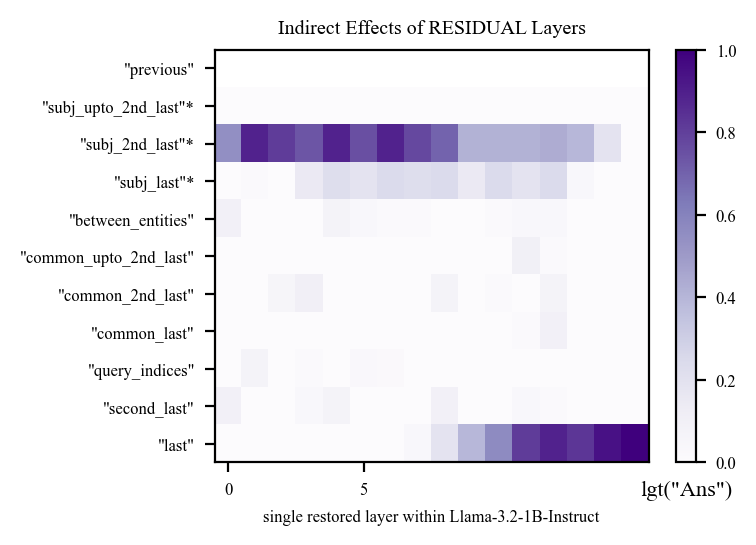

2025-06-26 10:56:14 __main__ INFO     (1/1) Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-26 10:56:14 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f3d88b75750>
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


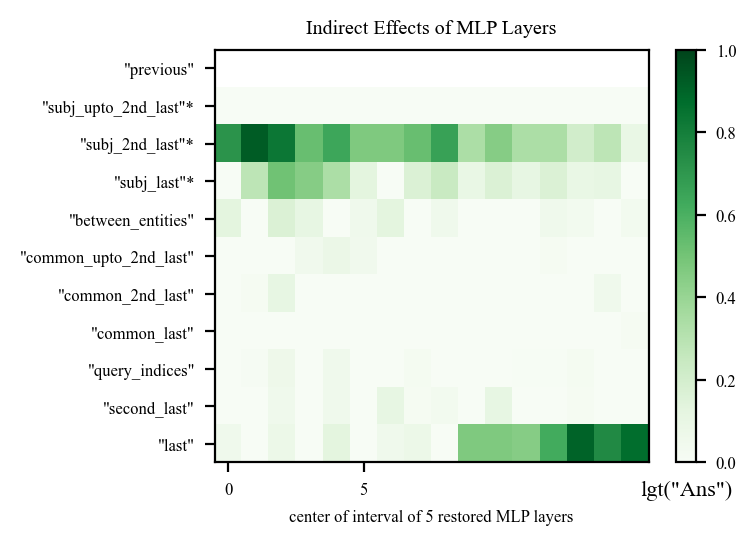

2025-06-26 10:56:14 __main__ INFO     (1/1) Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-26 10:56:14 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f3d88893d30>
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


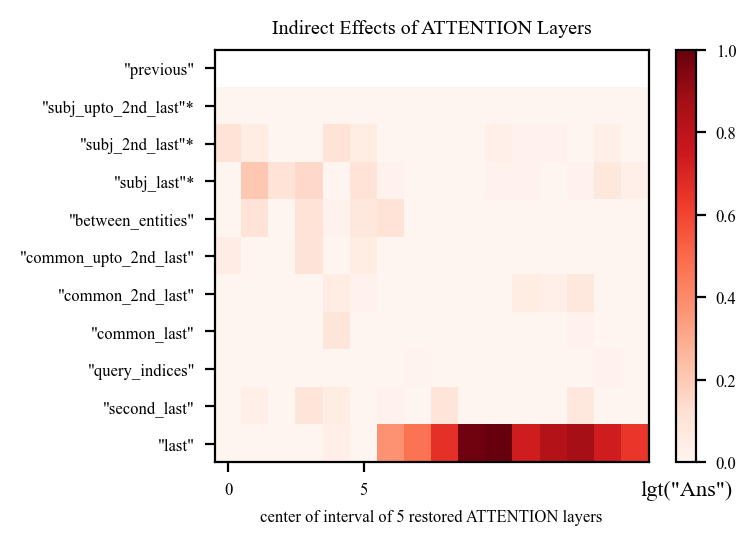

In [70]:
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
    look_dir = os.path.join(
        "results", "activation_patching", "test_72", target_attribute, kind
    )

    categorized_effects = []
    window, metric = None, None
    for idx, sample in enumerate(samples):
        logger.info(f"({idx + 1}/{len(samples)}) {sample}")

        file_name = f"{idx+1:04d}_{sample.patched_entity} - {sample.clean_entity}.npz"
        if file_name not in os.listdir(look_dir):
            logger.warning(f"Skipping {file_name}")
            continue

        trace_res = CausalTracingResult.from_npz(os.path.join(look_dir, file_name))
        window = trace_res.window
        metric = trace_res.metric
        token_ranges = get_token_ranges(mt, trace_res, common_entity=sample.common_entity)
        categorized_effects.append(
            get_categorized_indirect_effects(trace_res, token_ranges)
        )
    
    aie = average_indirect_effects(
        categorized_effects=categorized_effects,
        kind=kind,
        window=window,
        metric=metric
    )

    plot_trace_heatmap(
        result=aie,
        model_name=model_name,
        scale_range=(0, 1) if aie.normalized == True else None,
    )